In [124]:
import numpy as np
from astropy.table import Table,vstack
import matplotlib.pyplot as plt
from astropy.io import fits

maxindex = 100
stack = []

inputs = Table.read("data/pointlog.txt", format="ascii")

for index in range(maxindex):
    stack.append(Table.read("data/results_{}.txt".format(index), format="ascii"))
                            
def modellist(rtable):
    model = Table(names=rtable.colnames)
    oldk = rtable[0]['k']
    for row in rtable:
        if row['k']==oldk:
            model = vstack([model,row])
        else:
            yield model
            model = Table(row, names=rtable.colnames, )
        oldk = row['k']
    yield model

In [98]:
cellhist = {}

threshold = 3

resultid = 3

# Bin up the results
for row in stack[resultid]:
    rkey = str(int(row['cell']))
    if rkey in cellhist:
        cellhist[rkey] += 1
    else:
        cellhist[rkey] = 1

# Clear out the noiseh
noise = []        
for key in cellhist:
    if cellhist[key]<threshold:
        noise.append(key)
        
for key in noise:
    cellhist.pop(key, None)
        
cellhist


{'516616': 9,
 '516617': 70,
 '517641': 5,
 '521730': 3,
 '522748': 4,
 '522750': 20,
 '522751': 5,
 '523773': 8,
 '523774': 11,
 '523775': 5,
 '523776': 3,
 '523778': 3,
 '524798': 4,
 '524802': 4,
 '525825': 29,
 '525826': 38,
 '526848': 4,
 '526849': 3,
 '528894': 3}

In [99]:
keylist = list(cellhist.keys())

print(keylist)

cellcorr = Table(names=['ID'] + keylist)
cellanticorr = Table(names=['ID'] + keylist)
cellcorr['ID'].dtype = 'int32'
cellanticorr['ID'].dtype = 'int32'

for i in range(len(cellhist)):
    cellcorr.add_row([keylist[i]]+[0]*len(cellhist))
    cellanticorr.add_row([keylist[i]]+[0]*len(cellhist))
    cellcorr[keylist[i]].format = "%.3f"
    cellanticorr[keylist[i]].format = "%.3f"

n = 0    
testset = []
for model in modellist(stack[resultid]):
    n+=1
    if 518650 in model['cell']:
        testset.append(model['cell'])
    for A in cellhist:
        for B in cellhist:
            if int(A) in model['cell']:
                if int(B) in model['cell']:
                    cellcorr[A][keylist.index(B)] +=1.0#/float(cellhist[A])
                else:
                    cellanticorr[A][keylist.index(B)] +=1.0#/float(cellhist[A])

print(cellhist)
print(cellcorr)
print(cellanticorr)

['522750', '525825', '516617', '525826', '517641', '523773', '522748', '516616', '523776', '523774', '526849', '524798', '524802', '523778', '528894', '522751', '523775', '526848', '521730']
{'522750': 20, '525825': 29, '516617': 70, '525826': 38, '517641': 5, '523773': 8, '522748': 4, '516616': 9, '523776': 3, '523774': 11, '526849': 3, '524798': 4, '524802': 4, '523778': 3, '528894': 3, '522751': 5, '523775': 5, '526848': 4, '521730': 3}
  ID   522750 525825 516617 525826 517641 ... 528894 522751 523775 526848 521730
------ ------ ------ ------ ------ ------ ... ------ ------ ------ ------ ------
522750 20.000  9.000 17.000  9.000  0.000 ...  0.000  0.000  0.000  0.000  0.000
525825  9.000 29.000 21.000  0.000  1.000 ...  0.000  1.000  0.000  0.000  0.000
516617 17.000 21.000 70.000 31.000  0.000 ...  3.000  3.000  4.000  4.000  3.000
525826  9.000  0.000 31.000 38.000  4.000 ...  0.000  0.000  5.000  0.000  0.000
517641  0.000  1.000  0.000  4.000  5.000 ...  0.000  0.000  0.000  0.

522750 1022 1022
525825 1025 1025
516617 1033 1016
525826 1026 1025
517641 1033 1017
523773 1021 1023
522748 1020 1022
516616 1032 1016
523776 1024 1023
523774 1022 1023
526849 1025 1026
524798 1022 1024
524802 1026 1024
523778 1026 1023
528894 1022 1028
522751 1023 1022
523775 1023 1023
526848 1024 1026
521730 1026 1021


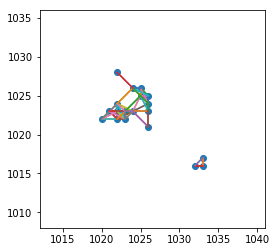

1028.67509475 1020.23921695


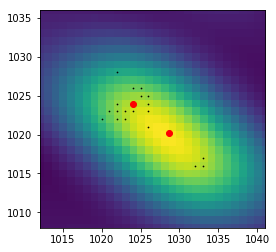

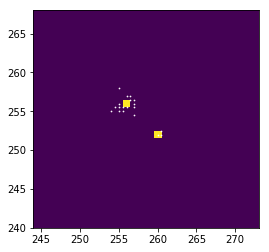

In [125]:
x = []
y = []
for index in cellhist:
    position = int(index)
    ny = int(float(position)/1024.0) 
    nx = position-ny*1024 
    x.append(nx+512)
    y.append(ny+512)
    print(index,nx+512,ny+512)

margin = 8

plt.axes().set_aspect("equal")
plt.xlim(min(x)-margin, max(x)+margin)
plt.ylim(min(y)-margin, max(y)+margin)
plt.scatter(x,y)

for row in cellhist:
    for colindex in range(len(cellhist)):
        value = cellcorr[row][colindex]
        col = list(cellhist.keys())[colindex]
        if value==0.0:
            position = int(row)
            ay = int(float(position)/1024.0)
            ax = position-ay*1024      
            ax += 512
            ay += 512
            position = int(col)
            by = int(float(position)/1024.0)
            bx = position-by*1024
            bx += 512
            by += 512
            r = np.sqrt((bx-ax)*(bx-ax) + (by-ay)*(by-ay))
            if r<3:
                plt.plot([ax,bx],[ay,by])

plt.show()

dmap = fits.open("data/simmap{}.alma.cycle2.6.noisy.image.fits".format(resultid))
plt.imshow(dmap[0].data[0,0])
plt.scatter(x,y, s=0.5, c='black')

realx = 1024+inputs[resultid]['r']*np.sin(inputs[resultid]['theta'])
realy = 1024+inputs[resultid]['r']*np.cos(inputs[resultid]['theta'])
print(realx,realy)
plt.scatter([1024,realx], [1024,realy], c='red')

plt.xlim(min(x)-margin, max(x)+margin)
plt.ylim(min(y)-margin, max(y)+margin)
plt.show()

rawmap = fits.open("data/simmap_{}.fits".format(resultid))
plt.imshow(rawmap[0].data[0,0])
plt.scatter((np.array(x)-512)/2.,(np.array(y)-512)/2., s=0.5, c='white')

plt.xlim(min(x)-margin-768, max(x)+margin-768)
plt.ylim(min(y)-margin-768, max(y)+margin-768)
plt.show()